In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

humansintheloop_semantic_segmentation_of_aerial_imagery_path = kagglehub.dataset_download('humansintheloop/semantic-segmentation-of-aerial-imagery')
charuagarwal01_vgg_unet__keras_default_1_path = kagglehub.model_download('charuagarwal01/vgg_unet_/Keras/default/1')
charuagarwal01_image_keras_default_1_path = kagglehub.model_download('charuagarwal01/image/Keras/default/1')
charuagarwal01_imge_keras_default_1_path = kagglehub.model_download('charuagarwal01/imge/Keras/default/1')
charuagarwal01_unet_model_keras_default_1_path = kagglehub.model_download('charuagarwal01/unet_model/Keras/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imge/keras/default/1/image_part_004.jpg
/kaggle/input/unet_model/keras/default/1/best_model_unet.keras
/kaggle/input/vgg_unet_/keras/default/1/best_model_vggunet (1).keras
/kaggle/input/image/keras/default/1/satellite-land-survey.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segment

# SATELLITE IMAGE SEGMENTATION

## Introduction

 Satellite image segmentation plays a crucial role in a wide range of geospatial applications, including land cover classification, urban planning, disaster response, and environmental monitoring. With the growing availability of high-resolution satellite imagery, there is a pressing need for accurate and automated segmentation techniques that can identify and classify distinct land features such as water bodies, vegetation, buildings, roads, and more.

In this project, we developed deep learning-based semantic segmentation models for satellite imagery using the **U-Net** architecture and a transfer learning-based variant with VGG19 as the encoder (VGG19 U-Net). The standard U-Net, known for its encoder-decoder structure and skip connections, is particularly effective for biomedical and remote sensing image segmentation due to its ability to capture both spatial and contextual information.

To enhance feature extraction and improve convergence, we employed transfer learning by replacing the encoder part of U-Net with a pre-trained VGG19 model trained on ImageNet. This hybrid model **VGG19-UNet** leverages the rich, hierarchical features learned from large-scale natural images and adapts them to the task of pixel-wise classification in satellite data.

## Dataset Description

The dataset consists of **aerial imagery of Dubai**, obtained by MBRSC (Mohammed Bin Rashid Space Centre) satellites, and annotated with pixel-wise semantic segmentation in six distinct classes. It is designed for training and evaluating semantic segmentation models on urban and natural landscapes.

- **Total Images**: 72
- **Grouped Tiles**: 8 large composite tiles
- **Image Type**: High-resolution RGB aerial imagery
- **Annotation Type**: Per-pixel semantic segmentation mask

#### Semantic Classes and Color Codes

| Class Name         | Description           | RGB Hex Code  |  Color         |
|--------------------|-----------------------|---------------| ---------------
| Building           | Man-made structures   | `#3C1098`     |  Indigo        |
| Land (unpaved area)| Bare ground/sand      | `#8429F6`     |  Purple        |
| Road               | Streets and highways  | `#6EC1E4`     |  Sky blue      |
| Vegetation         | Trees, grass, crops   | `#FEDD3A`     |  Golden Yellow |
| Water              | Rivers, lakes, etc.   | `#E2A929`     |  Mustard       |
| Unlabeled          | Background/undefined  | `#9B9B9B`     |  Grey          |


## Image and mask Preprocessing steps
- Patchification
- Image Normalisation using MinMaxScaler
- Label encoding of masks
- Creating Generators
- Data Augmentation

## Import Packages


In [ ]:
!pip install patchify
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2025-07-19 06:33:11.941155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752906792.326796      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752906792.428998      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing

In [ ]:
dataset_root_folder = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

#### Reading an image

In [ ]:
patch_size =256
image = cv2.imread(f'{dataset_root_folder}/Tile 1/images/image_part_001.jpg',1)
image

array([[[201, 195, 190],
        [225, 219, 214],
        [241, 232, 228],
        ...,
        [255, 236, 231],
        [254, 234, 229],
        [255, 239, 234]],

       [[226, 220, 215],
        [254, 248, 243],
        [255, 255, 251],
        ...,
        [252, 231, 229],
        [247, 228, 223],
        [242, 223, 218]],

       [[248, 241, 238],
        [255, 252, 249],
        [255, 255, 251],
        ...,
        [253, 234, 231],
        [252, 235, 232],
        [245, 228, 225]],

       ...,

       [[211, 200, 203],
        [220, 209, 212],
        [221, 211, 217],
        ...,
        [220, 229, 242],
        [234, 243, 255],
        [235, 244, 255]],

       [[209, 198, 201],
        [219, 208, 211],
        [220, 210, 216],
        ...,
        [213, 222, 235],
        [222, 231, 244],
        [218, 227, 240]],

       [[213, 202, 205],
        [210, 199, 202],
        [201, 191, 197],
        ...,
        [223, 232, 245],
        [233, 242, 255],
        [230, 239, 252]]

In [ ]:
image.shape

(644, 797, 3)

#### Examining the shapes of satellite images

In [ ]:
image_extension = 'jpg'
image_type = 'images'
count=0
for tile_id in range(1,9):
  for image_id in range(1,10):
    image = cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_{image_id:03d}.{image_extension}',1)
    if image is not None:
      print(image.shape) #imread return numpy array image
      count+=1
print(f"Total found images: {count}")

(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(643, 797, 3)
(643, 797, 3)
(643, 797, 3)
(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)
(2062, 1817, 3)
(2062, 1816, 3)
(2062, 1817, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)
(1479, 2149, 3)
(1479, 2149, 3)
(1479, 2149, 3)
(1480, 2149, 3)
(1480, 21

Total images found are 72. We observe that we have varying image sizes which are incompatible with the fixed input dimensions required by CNN-based architectures. To make the image size consistent, we use the patchification concept, which involves dividing each large image into smaller, fixed-size patches.

**Patchification Process**

- Each image is divided into non-overlapping patches of a consistent shape, such as 256×256.
- Corresponding segmentation masks are also patchified using the same grid to maintain pixel wise alignment between the input image and its label.
- This transformation increases the total number of training samples and helps in better generalization.


**Image Normalization using MinMaxScaler**  
 This ensures that pixel values are scaled to the [0, 1] range, improving the stability and convergence of the deep learning models.

In [ ]:
image_dataset = []
mask_dataset = []
minmaxscalar = MinMaxScaler()

for image_type in ['images', 'masks']:
    image_extension = 'jpg' if image_type == 'images' else 'png'
    for tile_id in range(1, 9):
        for image_id in range(1,10):
            path = f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_{image_id:03d}.{image_extension}'
            image = cv2.imread(path, 1)

            if image is not None:
                if image_type == "masks":
                  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converting masks in RGB format
                size_x = (image.shape[1] // patch_size) * patch_size  # width
                size_y = (image.shape[0] // patch_size) * patch_size  # height

                image = Image.fromarray(image) #array back to image
                image = image.crop((0, 0, size_x, size_y)) ##left, upper, right, lower
                image = np.array(image)

                patched_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patched_image.shape[0]):
                    for j in range(patched_image.shape[1]):
                       if image_type == 'images':
                          patch_image = patched_image[i, j, 0]

                        # Flatten for MinMaxScaler
                          reshaped = patch_image.reshape(-1, 3)
                          scaled_patch = minmaxscalar.fit_transform(reshaped).reshape(patch_image.shape)
                          image_dataset.append(scaled_patch)
                       else:
                          patch_mask = patched_image[i, j, 0]
                          mask_dataset.append(patch_mask)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

1305
1305


After patchification, we have 1305 images and 1305 corresponding masks each of size (256,256,3).

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

#### Rendering images

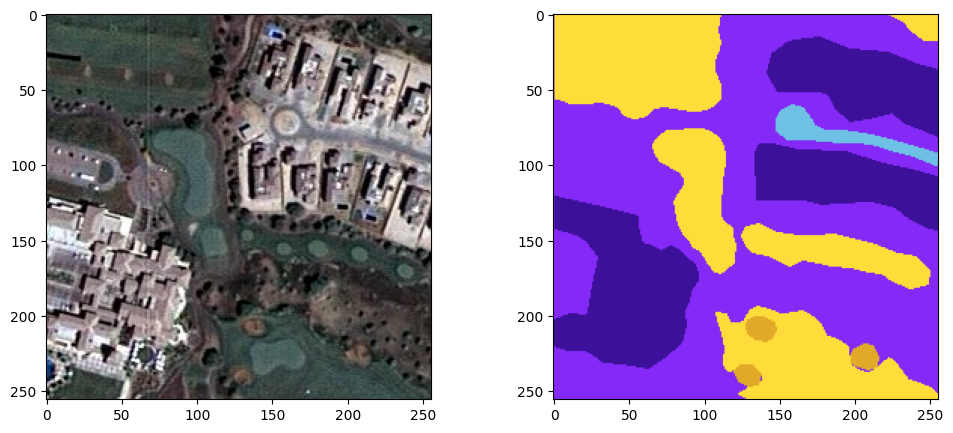

In [ ]:
random_number = np.random.randint(0, len(image_dataset))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image_dataset[random_number])
axes[1].imshow(mask_dataset[random_number])


**Mask Conversion**:
  - For model training, RGB-encoded segmentation masks are converted into integer-encoded class labels 0-5 using a predefined colormap.
  - For visualization, predicted masks or label-encoded masks are converted back to RGB format to visually inspect segmentation performance against the original annotations.

#### Converting hexadecimal colours to labels

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)


class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)


class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation )


class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)


class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)
#RGB Value	Approximate Color Name
#[ 60, 16, 152]	Dark Violet / Indigo building
#[132, 41, 246]	Bright Purple / Blue-Violet land
#[110, 193, 228]	Sky Blue / Light Cyan road
#[254, 221, 58]	Yellow / Golden Yellow vegetation
#[226, 169, 41]	Mustard / Amber  water
#[155, 155, 155]	Medium Gray / Ash

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
def rgb_to_label(mask_dataset):

    label_dataset = []

    for mask in mask_dataset:
       label_mask = np.zeros(mask.shape[:2], dtype = np.uint8)
       label_mask[np.all(mask == class_water, axis=-1)] = 0  # Water
       label_mask[np.all(mask == class_land, axis=-1)] = 1    # Land (unpaved area)
       label_mask[np.all(mask == class_road, axis=-1)] = 2  # Road
       label_mask[np.all(mask == class_building, axis=-1)] = 3  # Building
       label_mask[np.all(mask == class_vegetation, axis=-1)] = 4  # Vegetation
       label_mask[np.all(mask == class_unlabeled, axis=-1)] = 5  # Unlabeled

       label_dataset.append(label_mask)

    return np.array(label_dataset)


#### Applying rgb_to_label function on mask dataset to convert RGB pixels into labels.

In [ ]:
mask_label_dataset = rgb_to_label(mask_dataset)
mask_label_dataset

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 5, 5, ..., 0, 0, 0],
        [1, 5, 5, ..., 0, 0, 0],
        [1, 1, 5, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 

In [ ]:
mask_label_dataset.shape

(1305, 256, 256)

In [ ]:
print('Total unique lables on masks:',np.unique(mask_label_dataset))

Total unique lables on masks: [0 1 2 3 4 5]


In [ ]:
total_classes = np.unique(mask_label_dataset)
total_classes

array([0, 1, 2, 3, 4, 5], dtype=uint8)

#### Converting mask labels into one hot encoded labels

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(mask_label_dataset))
labels_categorical_dataset = to_categorical(mask_label_dataset, num_classes)
labels_categorical_dataset

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.

In [ ]:
labels_categorical_dataset.shape

(1305, 256, 256, 6)

#### The shape of the mask dataset now becomes (1305,256,256,6) after categorical labelling.

In [ ]:
master_training_dataset = image_dataset
master_training_dataset.shape

(1305, 256, 256, 3)

Due to the size and complexity of the dataset, it would be impractical to load all of the images into memory at once. Therefore, we will be using data generators to generate batches of images on-the-fly during training, which will allow us to efficiently train our model on the entire dataset.

In addition, we will be applying various data augmentation techniques to the training images,  to increase the diversity of our training set, which can improve the performance of our deep learning model. By introducing variability into the training process, data augmentation can also help to prevent overfitting, which occurs when the model becomes too closely tailored to the training set and performs poorly on new, unseen data.

**Augmentation Techniques Applied**:
- Horizontal flipping
- Vertical flipping
- Rotation (e.g., 90°, 180°, 270°)

#### Train generator

In [ ]:
def augment_image_and_mask(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask

def train_augmented_generator(images, masks, indices, batch_size=32, augment=True):
    while True:
        np.random.shuffle(indices) ## Reshuffle every epoch
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_ids = indices[start:end]
            X_batch = images[batch_ids]
            Y_batch = masks[batch_ids]

            batch_images = []
            batch_masks = []

            for x, y in zip(X_batch, Y_batch):
                x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
                y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
                if augment:
                   x_tf, y_tf = augment_image_and_mask(x_tf, y_tf) #augmenting
                batch_images.append(x_tf)
                batch_masks.append(y_tf)


            yield tf.stack(batch_images), tf.stack(batch_masks)


#### Validation and test generator

In [ ]:
def simple_generator(images, masks, indices, batch_size=32, augment=False):
    while True:
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_ids = indices[start:end]
            X_batch = images[batch_ids]
            Y_batch = masks[batch_ids]

            batch_images = tf.convert_to_tensor(X_batch, dtype=tf.float32)
            batch_masks = tf.convert_to_tensor(Y_batch, dtype=tf.float32)

            yield batch_images, batch_masks

#### Splitting the data in training, validation and testing sets.

In [ ]:
total_samples = master_training_dataset.shape[0]
indices = np.arange(total_samples)
np.random.seed(42)
np.random.shuffle(indices)

# Split indices (e.g., 70-20-10)
train_idx = indices[:int(0.7 * total_samples)]
val_idx   = indices[int(0.7 * total_samples):int(0.9 * total_samples)]
test_idx  = indices[int(0.9 * total_samples):]

# Create generators
train_gen = train_augmented_generator(master_training_dataset, labels_categorical_dataset, train_idx, batch_size=16)
val_gen   = simple_generator(master_training_dataset, labels_categorical_dataset, val_idx, batch_size=16)
test_gen  = simple_generator(master_training_dataset, labels_categorical_dataset, test_idx, batch_size=16)

# U-Net Model

The U-Net model is a convolutional neural network architecture specifically designed for semantic segmentation tasks. It was originally developed for biomedical image segmentation but has since proven highly effective for other domains like satellite and aerial imagery. U-Net follows an encoder–decoder structure with skip connections that directly link corresponding layers from the downsampling (encoder) and upsampling (decoder) paths. These skip connections help retain fine-grained spatial information lost during downsampling. The model captures both context and precise localization, making it ideal for pixel-wise classification in tasks such as land cover mapping and building detection in satellite images.



![image.png](attachment:2a7d2fe3-312c-4e17-ac2a-e2dc150fef78.png)

### Model Building

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D , Conv2DTranspose , Activation
from keras.layers import concatenate, BatchNormalization, Dropout

##### Dropout layers are added to prevent overfitting.

In [ ]:
def unet_model(image_height=256, image_width=256, image_channels=3, n_classes=6, initial_filters=16, factor=2):
    inputs = Input((image_height, image_width, image_channels))

    # Encoder
    n_filters = initial_filters
    c1 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(inputs)
    #c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c1)
    c1 = Activation("relu")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    n_filters *= factor
    c2 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(p1)
    #c2 = BatchNormalization()(c2)
    c2 = Activation("relu")(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c2)
    c2 = Activation("relu")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    n_filters *= factor
    c3 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(p2)
    #c3 = BatchNormalization()(c3)
    c3 = Activation("relu")(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c3)
    c3 = Activation("relu")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    n_filters *= factor
    c4 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(p3)
    #c4 = BatchNormalization()(c4)
    c4 = Activation("relu")(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c4)
    c4 = Activation("relu")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    n_filters *= factor
    c5 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(p4)
   # c5 = BatchNormalization()(c5)
    c5 = Activation("relu")(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c5)
    c5 = Activation("relu")(c5)


    # Decoder
    n_filters //= factor
    u6 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(u6)
   # c6 = BatchNormalization()(c6)
    c6 = Activation("relu")(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c6)
    c6 = Activation("relu")(c6)

    n_filters //= factor
    u7 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(u7)
   # c7 = BatchNormalization()(c7)
    c7 = Activation("relu")(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c7)
    c7 = Activation("relu")(c7)


    n_filters //= factor
    u8 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(u8)
    #c8 = BatchNormalization()(c8)
    c8 = Activation("relu")(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c8)
    c8 = Activation("relu")(c8)


    n_filters //= factor
    u9 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(u9)
   # c9 = BatchNormalization()(c9)
    c9 = Activation("relu")(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer='he_normal')(c9)
    c9 = Activation("relu")(c9)

    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


To optimize model training and ensure better generalization, several Keras callbacks are used. EarlyStopping helps to prevent overfitting. ModelCheckpoint automatically saves the model with the best validation performance during training. A CSVLogger records epoch-wise training and validation metrics for later analysis. Additionally, ReduceLROnPlateau  reduces the learning rate dynamically when the validation loss plateaued, enabling finer convergence and avoiding local minima.


In [ ]:
#Callbacks - Early stopping, ModelCheckpoint, CSV logger and ReduceOnPlateau

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

def get_unet_callbacks(
    checkpoint_path,
    log_filename,
    monitor_metric='val_dice_coef',
    early_stop_monitor='val_loss',
    early_stop_patience=8,
    reduce_lr_monitor='val_loss',
    reduce_lr_factor=0.5,
    reduce_lr_patience=3,
    min_lr=1e-6
):
    checkpointer = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=monitor_metric,
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )

    reduce_lr = ReduceLROnPlateau(
        monitor=reduce_lr_monitor,
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        min_lr=min_lr,
        verbose=1
    )

    csv_logger = CSVLogger(log_filename)

    early_stopper = EarlyStopping(
        monitor=early_stop_monitor,
        patience=early_stop_patience,
        restore_best_weights=True
    )

    return [early_stopper, checkpointer, csv_logger, reduce_lr]

In [ ]:
callbacks = get_unet_callbacks(
    checkpoint_path='best_model_unet.keras',
    log_filename='training_log.csv'
)

**Utilising focal loss and dice loss as loss functions**

To improve the learning process for all classes equally, uniform class weights were assigned across the six segmentation classes. The Dice Loss, which emphasizes the overlap between predicted and ground truth masks, was weighted using these class weights to ensure balanced learning. Additionally, Categorical Focal Loss was employed to focus training on difficult and misclassified pixels. The final loss function used during training was a combination of both.

Total Loss=Dice Loss+1×Focal Loss.
This composite loss helped the model learn both boundary precision and class-level discrimination more effectively.

In [ ]:
! pip install -U git+https://github.com/qubvel/segmentation_models.git
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-l4ev4n_v
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-l4ev4n_v
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=1cd40f8bdb9911d315366a3e3f9c0393b97974dbc69ce0e98dcf9245f1334869
  Stored in directory: /tmp/pip-ephem-wheel-cache-juqoccqn/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models
Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
class_weight = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights= class_weight)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [ ]:
#creating unet model
model_1 =  unet_model()
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_54             │ (None, 256, 256, 16)   │              0 │ conv2d_57[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_54[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_55             │ (None, 256, 256, 16)   │              0 │ conv2d_58[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 128, 128, 16)   │              0 │ activation_55[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_56             │ (None, 128, 128, 32)   │              0 │ conv2d_59[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 128, 128, 32)   │              0 │ activation_56[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_57             │ (None, 128, 128, 32)   │              0 │ conv2d_60[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 32)     │              0 │ activation_57[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_58             │ (None, 64, 64, 64)     │              0 │ conv2d_61[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout) 

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001

**Defining Jaccard Coefficient and Dice Coefficient as Metrics**

To evaluate the performance of the segmentation models, both the Jaccard Coefficient (Intersection over Union) and the Dice Coefficient were used as metrics. The Jaccard Coefficient measures the ratio of the intersection over the union of predicted and ground truth masks, providing a reliable estimate of overlap quality. The Dice Coefficient, measures the similarity of two groups by dividing twice the intersection token count by the total token count of both groups.

In [ ]:
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

#### Compiling model

In [ ]:
optimizer = Adam(learning_rate=learning_rate)
model_1.compile(
   optimizer = optimizer,
   loss = total_loss,
   metrics = [jacard_coef, dice_coef,
        CategoricalAccuracy(name='accuracy')] #compute pixel-wise accuracy.

)

#### UNet Model fitting

In [ ]:
import math
steps_per_epoch = math.ceil(len(train_idx) / 16)
val_steps = math.ceil(len(val_idx) / 16)
model_1_history = model_1.fit(train_gen,
                        validation_data=val_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps,
                        epochs=60, verbose=1, callbacks= callbacks)


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4942 - dice_coef: 0.3235 - jacard_coef: 0.1979 - loss: 1.0094
Epoch 1: val_dice_coef improved from -inf to 0.53212, saving model to best_model_unet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 547ms/step - accuracy: 0.4953 - dice_coef: 0.3249 - jacard_coef: 0.1989 - loss: 1.0092 - val_accuracy: 0.6480 - val_dice_coef: 0.5321 - val_jacard_coef: 0.3645 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7054 - dice_coef: 0.5955 - jacard_coef: 0.4276 - loss: 0.9680
Epoch 2: val_dice_coef improved from 0.53212 to 0.61270, saving model to best_model_unet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step - accuracy: 0.7056 - dice_coef: 0.5960 - jacard_coef: 0.4281 - loss: 0.9679 - val_accuracy: 0.6996 - val_dice_coef: 0.6127 - val_jacard_coef: 0.4432 - val_loss: 0.9656 - learning_rate: 0.0010
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7272 - dice_coef: 0.642

#### Plotting train and validation performances

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, title="Training vs Validation Metrics"):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16)

    # 1. Train vs Val Loss
    axs[0, 0].plot(history.history['loss'], label='Train Loss')
    axs[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 2. Train vs Val Jaccard Coefficient
    axs[0, 1].plot(history.history['jacard_coef'], label='Train Jaccard Coefficient')
    axs[0, 1].plot(history.history['val_jacard_coef'], label='Val Jaccard Coefficient')
    axs[0, 1].set_title('Jaccard Coefficient')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Train vs Val Accuracy
    axs[1, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[1, 0].set_title('Accuracy')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # 4. Train vs Val Dice Coefficient
    axs[1, 1].plot(history.history['dice_coef'], label='Train Dice Coefficient')
    axs[1, 1].plot(history.history['val_dice_coef'], label='Val Dice Coefficient')
    axs[1, 1].set_title('Dice Coefficient')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

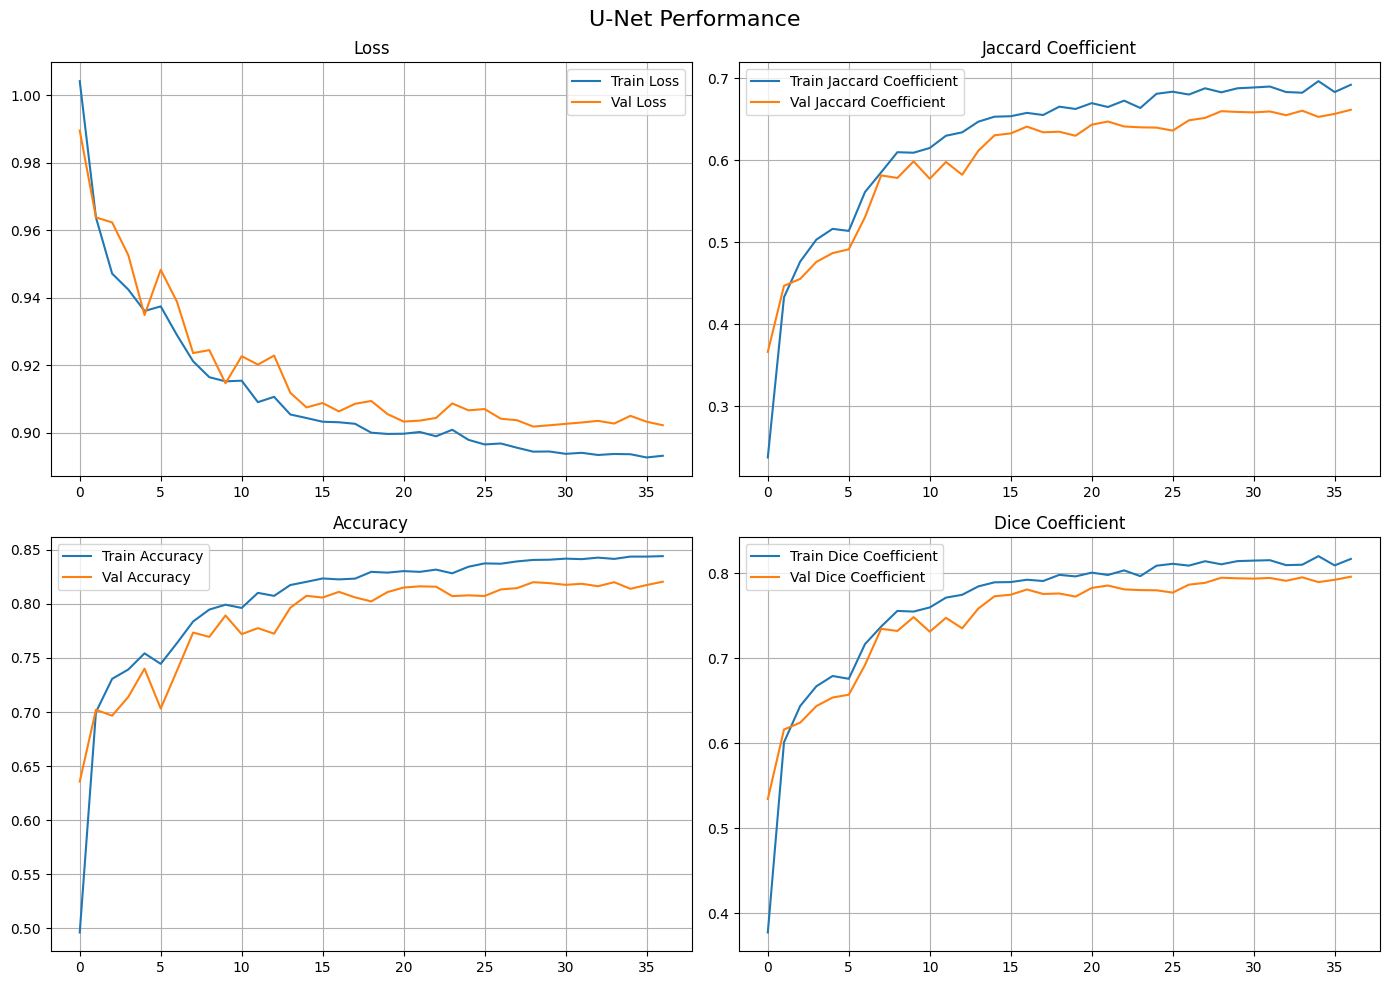

In [ ]:
plot_training_metrics(model_1_history, title="U-Net Performance")

In [ ]:
#saving trained model
from IPython.display import FileLink
FileLink('best_model_unet.keras')

/kaggle/working/best_model_unet.keras

# Model performance evaluation

In [ ]:
import math

def evaluate_val_performance(model, generator, batch_size=16, set_name="Validation"):
    steps = math.ceil(len(val_idx) / batch_size)
    loss, acc, dice, jaccard = model.evaluate(generator, steps=steps, verbose=0)

    print(f"\n{set_name} Performance:")
    print(f"{set_name} Loss: {loss:.4f}")
    print(f"{set_name} Accuracy: {acc:.4f}")
    print(f"{set_name} Dice Coefficient: {dice:.4f}")
    print(f"{set_name} Jaccard Coefficient: {jaccard:.4f}")

In [ ]:
import math

def evaluate_test_performance(model, generator, batch_size=16, set_name="Test"):
    steps = math.ceil(len(test_idx) / batch_size)
    loss, acc, dice, jaccard = model.evaluate(generator, steps=steps, verbose=0)

    print(f"\n{set_name} Performance:")
    print(f"{set_name} Loss: {loss:.4f}")
    print(f"{set_name} Accuracy: {acc:.4f}")
    print(f"{set_name} Dice Coefficient: {dice:.4f}")
    print(f"{set_name} Jaccard Coefficient: {jaccard:.4f}")

In [ ]:
from tensorflow.keras.models import load_model

#### Loading the trained UNet model

In [ ]:
unet_model = load_model('/kaggle/input/unet_model/keras/default/1/best_model_unet.keras', custom_objects={
    'dice_coef': dice_coef,
    'jacard_coef': jacard_coef
}, compile=False)

I0000 00:00:1751376747.522438      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751376747.523112      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
optimizer = Adam(learning_rate=learning_rate)
unet_model.compile(
   optimizer = optimizer,
   loss = total_loss,
   metrics = [jacard_coef, dice_coef,
        CategoricalAccuracy(name='accuracy')] #compute pixel-wise accuracy.

)

#### Plotting the images and predicted masks

In [ ]:
def label_to_rgb(predicted_image):

    class_building = '#3C1098'
    class_building = class_building.lstrip('#')
    class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))

    class_land = '#8429F6'
    class_land = class_land.lstrip('#')
    class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))

    class_road = '#6EC1E4'
    class_road = class_road.lstrip('#')
    class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))


    class_vegetation = '#FEDD3A'
    class_vegetation = class_vegetation.lstrip('#')
    class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))

    class_water = '#E2A929'
    class_water = class_water.lstrip('#')
    class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))


    class_unlabeled = '#9B9B9B'
    class_unlabeled = class_unlabeled.lstrip('#')
    class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))

    segmented_image = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3), dtype=np.uint8)
    segmented_image[(predicted_image == 0)] = class_water
    segmented_image[(predicted_image == 1)] = class_land
    segmented_image[(predicted_image == 2)] = class_road
    segmented_image[(predicted_image == 3 )] = class_building
    segmented_image[(predicted_image == 4 )] = class_vegetation
    segmented_image[(predicted_image == 5 )] = class_unlabeled


    return segmented_image


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf

color_map = np.array([
     [226, 169, 41],  # 0 - Water
    [132, 41, 246],   # 1 - Land
    [110,193,228],   # 2 - Road
    [60, 16, 152],    # 3 - Building
    [254, 221, 58],   # 4 - Vegetation
    [155, 155, 155],  # 5 - Unlabeled
], dtype=np.uint8)

class_labels = {
      "Road": [110, 193, 228],
    "Water": [226, 169, 41],
    "Land": [132, 41, 246],
    "Building": [60, 16, 152],
    "Vegetation": [254, 221, 58],
    "Unlabeled": [155, 155, 155],
}

def label_to_rgb(label_mask, color_map=color_map):
    return color_map[label_mask]

def prediction(generator, model, n=5):
    images, true_masks = next(generator)
    preds = model.predict(images)

    indices = np.random.choice(len(images), size=n, replace=False)
    plt.figure(figsize=(14, 3*n))

    for row, idx in enumerate(indices):
        image = images[idx]
        true_mask = tf.argmax(true_masks[idx], axis=-1).numpy()
        pred_mask = tf.argmax(preds[idx], axis=-1).numpy()

        true_rgb = label_to_rgb(true_mask)
        pred_rgb = label_to_rgb(pred_mask)

        # Input Image
        plt.subplot(n, 3, row * 3 + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        # True Mask
        plt.subplot(n, 3, row * 3 + 2)
        plt.imshow(true_rgb)
        plt.title("True Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(n, 3, row * 3 + 3)
        plt.imshow(pred_rgb)
        plt.title("Predicted Mask")
        plt.axis("off")


    patches = [mpatches.Patch(color=np.array(rgb)/255, label=label) for label, rgb in CLASS_LABELS.items()]
    plt.legend(handles=patches, loc='lower left', title="Legend")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


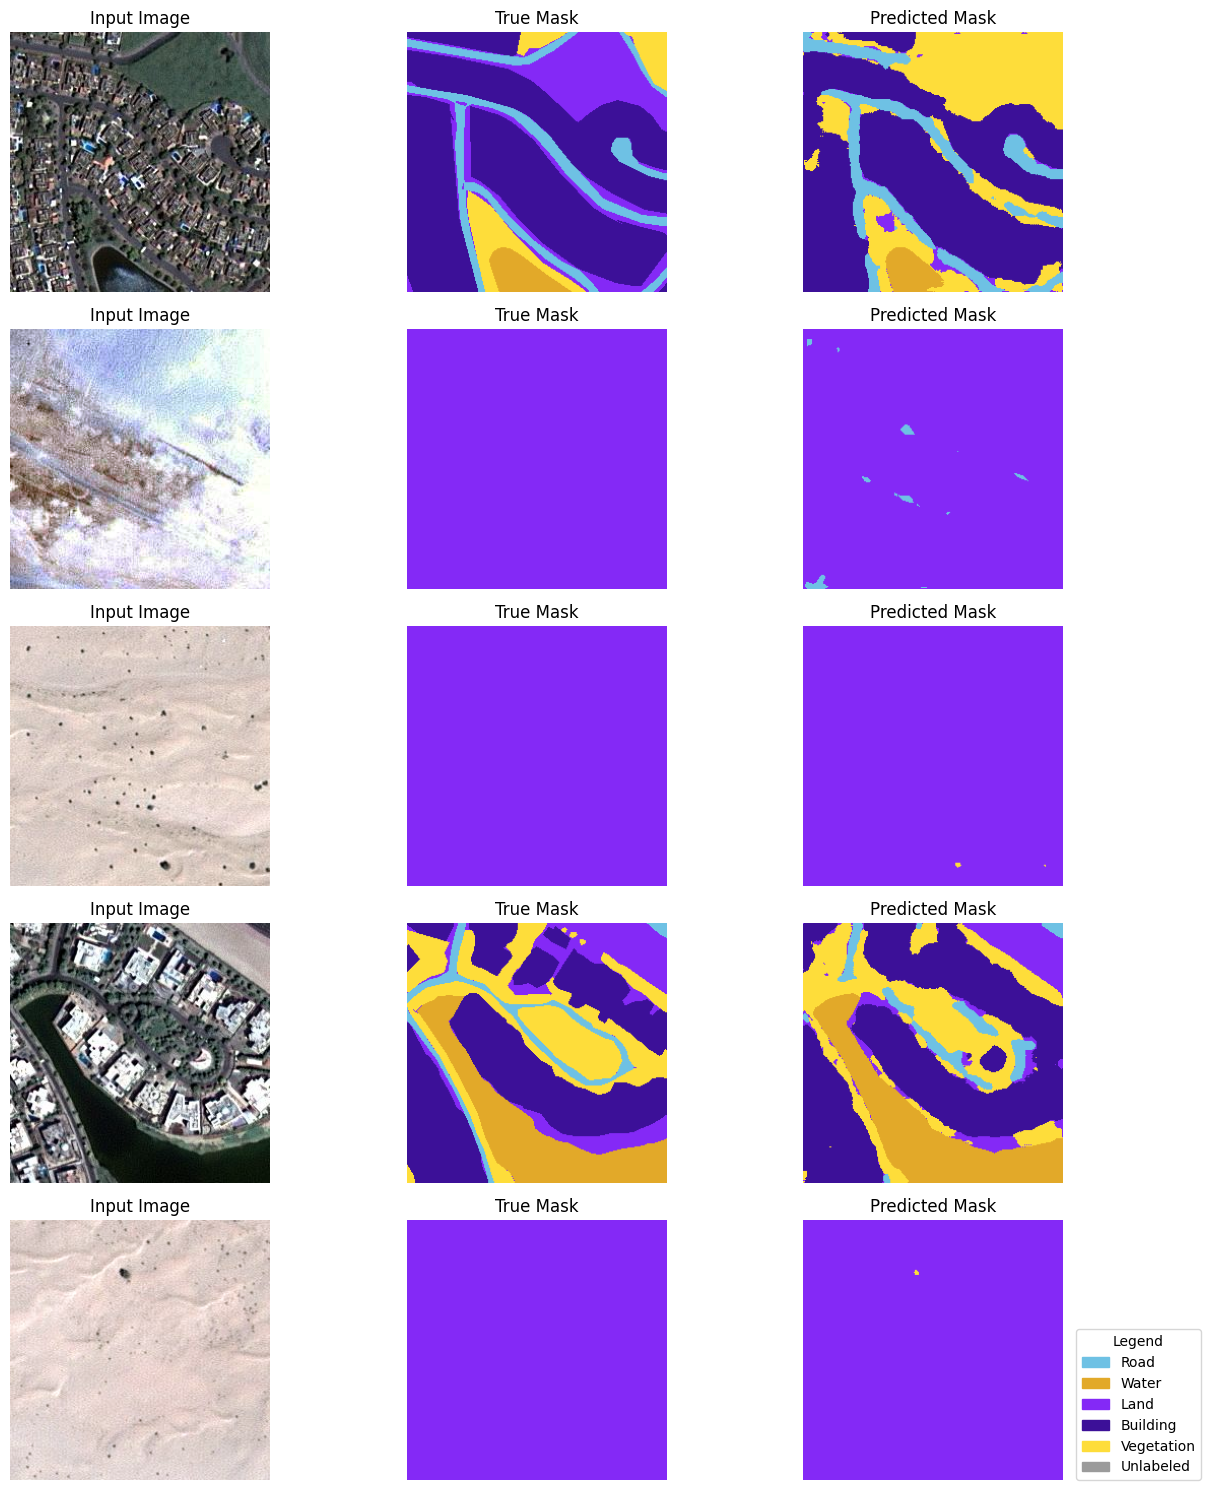

In [ ]:
prediction(test_gen, unet_model)

# VGG19-UNet Model

### Model Building

![image.png](attachment:8d93cc5c-ee0a-41de-b101-3bd96335c0cf.png)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    return x

def decoder_block(input_tensor, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def vgg19_unet(input_shape=(256, 256, 3), n_classes=6):
    inputs = Input(input_shape)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder layer
    s1 = vgg19.get_layer("block1_conv2").output  # 256x256
    s2 = vgg19.get_layer("block2_conv2").output  # 128x128
    s3 = vgg19.get_layer("block3_conv4").output  # 64x64
    s4 = vgg19.get_layer("block4_conv4").output  # 32x32

    # Bottleneck
    b1 = vgg19.get_layer("block5_conv4").output  # 16x16

   #Decoder layers
    d1 = decoder_block(b1, s4, 512)  # 32x32
    d2 = decoder_block(d1, s3, 256)  # 64x64
    d3 = decoder_block(d2, s2, 128)  # 128x128
    d4 = decoder_block(d3, s1, 64)   # 256x256

    outputs = Conv2D(n_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG19-U-Net")
    return model

In [ ]:
#Printing model summary
model_2 =  vgg19_unet()
model_2.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG19-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,172,358 (118.91 MB)

 Trainable params: 31,168,518 (118.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

#### Compiling the model

In [ ]:
optimizer = Adam(learning_rate=0.001)  # or any config you like

model_2.compile(
   optimizer = optimizer,
   loss = total_loss,
   metrics = [jacard_coef, dice_coef,
        CategoricalAccuracy(name='accuracy')] #compute pixel-wise accuracy.

)

#### Defining callbacks for the model


In [ ]:
callbacks = get_unet_callbacks(
checkpoint_path='best_model_vggunet.keras',
log_filename='training_log_2.csv'
)

#### Fitting the VGG19-UNet model

In [ ]:
model_2_history = model_2.fit(train_gen,
                        validation_data=val_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps,
                        epochs=80, verbose=1, callbacks= callbacks)



Epoch 1/80


2025-06-26 13:23:13.161111: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-26 13:23:13.246301: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.085338568s
Trying algorithm eng12{k11=0} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

57/58 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6462 - dice_coef: 0.5235 - jacard_coef: 0.3676 - loss: 0.9750

E0000 00:00:1750944339.380850     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750944339.647191     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750944341.627848     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750944341.834528     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6476 - dice_coef: 0.5251 - jacard_coef: 0.3690 - loss: 0.9746

E0000 00:00:1750944390.921145     181 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750944391.156712     181 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_dice_coef improved from -inf to 0.25483, saving model to best_model_vggunet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.6489 - dice_coef: 0.5266 - jacard_coef: 0.3703 - loss: 0.9743 - val_accuracy: 0.2526 - val_dice_coef: 0.2548 - val_jacard_coef: 0.1474 - val_loss: 1.4375 - learning_rate: 0.0010
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7898 - dice_coef: 0.7108 - jacard_coef: 0.5525 - loss: 0.9351
Epoch 2: val_dice_coef improved from 0.25483 to 0.32500, saving model to best_model_vggunet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7897 - dice_coef: 0.7109 - jacard_coef: 0.5526 - loss: 0.9351 - val_accuracy: 0.3478 - val_dice_coef: 0.3250 - val_jacard_coef: 0.1956 - val_loss: 1.1517 - learning_rate: 0.0010
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8002 - dice_coef: 0.7370 - jacard_coef: 0.5844 - loss: 0.9279
Epoch 3: val_dice_coef improved from 0.32500 to 0.67726, saving model to best_model_vggunet.k

#### Plotting model performance on train and test data

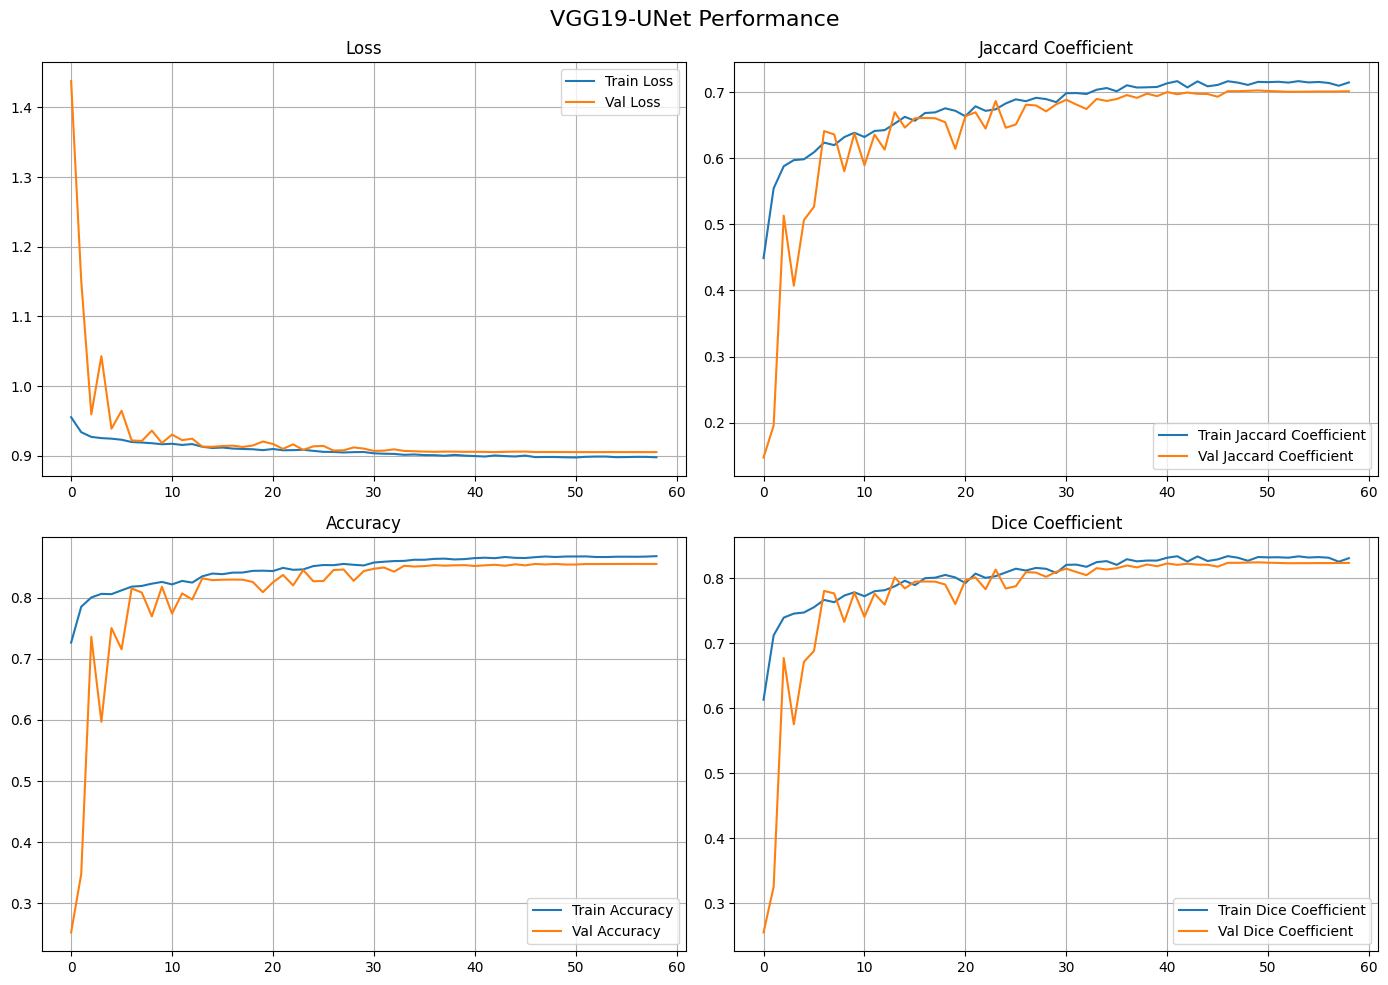

In [ ]:
plot_training_metrics(model_2_history, title="VGG19-UNet Performance")

In [ ]:
#Saving the model
from IPython.display import FileLink
FileLink('best_model_vggunet.keras')

/kaggle/working/best_model_vggunet.keras

# Model Evaluation

In [ ]:
vgg_unet_model = load_model('/kaggle/input/vgg_unet_/keras/default/1/best_model_vggunet (1).keras', custom_objects={
    'dice_coef': dice_coef,
    'jacard_coef': jacard_coef
}, compile=False)

I0000 00:00:1751442821.726145      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751442821.726833      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
optimizer = Adam(learning_rate=learning_rate)
vgg_unet_model.compile(
   optimizer = optimizer,
   loss = total_loss,
   metrics = [jacard_coef, dice_coef,
        CategoricalAccuracy(name='accuracy')] #compute pixel-wise accuracy.

)

#### Making predictions on test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


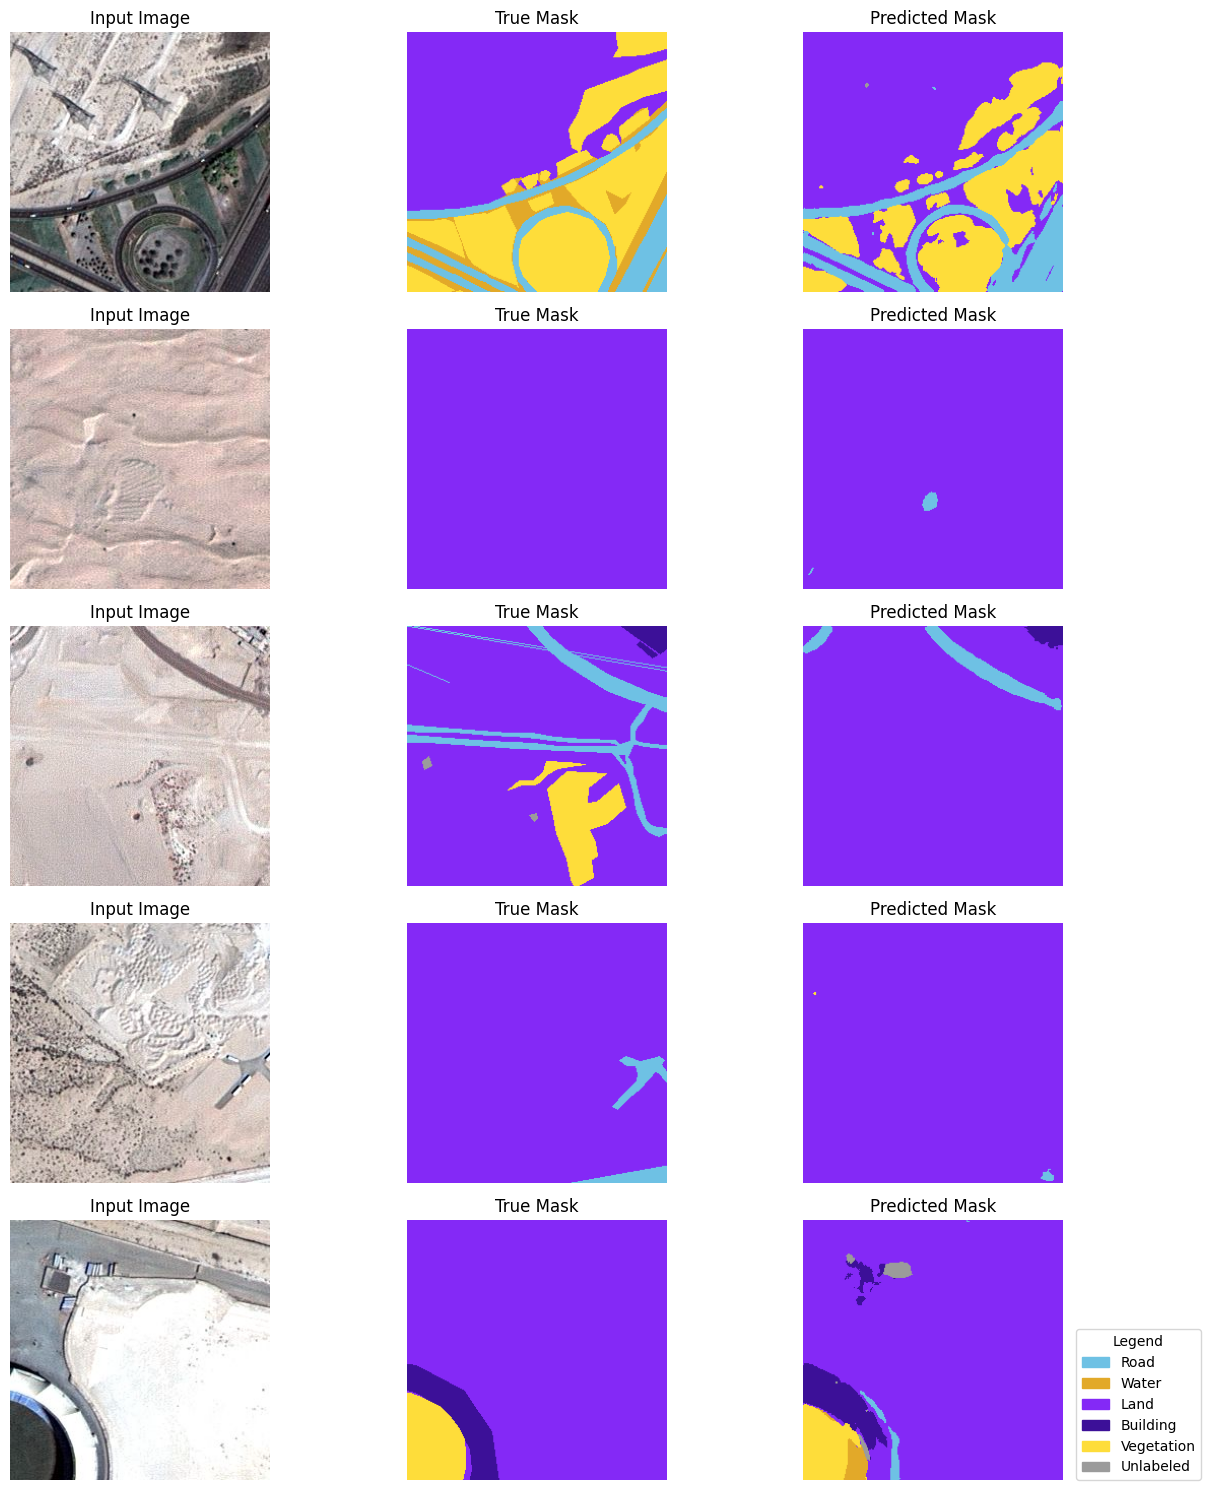

In [ ]:
prediction(test_gen, vgg_unet_model)

# Comparing performance of UNet and VGG19-UNet model

In [ ]:
batch_size=16
test_steps = math.ceil(len(test_idx) / batch_size)
test_loss_unet, test_acc_unet, test_dice_unet, test_jaccard_unet = unet_model.evaluate(test_gen, verbose=0, steps=test_steps)
test_loss_vgg, test_acc_vgg, test_dice_vgg, test_jaccard_vgg = vgg_unet_model.evaluate(test_gen, verbose=0 , steps=test_steps)

val_steps = math.ceil(len(val_idx) / batch_size)
val_loss_unet, val_acc_unet, val_dice_unet, val_jaccard_unet = unet_model.evaluate(val_gen, verbose=0, steps=val_steps)
val_loss_vgg, val_acc_vgg, val_dice_vgg, val_jaccard_vgg = vgg_unet_model.evaluate(val_gen, verbose=0, steps=val_steps)

data = {
    "Model": ["U-Net", "VGG19 U-Net"],

    "Val Accuracy": [val_acc_unet, val_acc_vgg],
    "Val Dice": [val_dice_unet, val_dice_vgg],
    "Val Jaccard": [val_jaccard_unet, val_jaccard_vgg],
    "Val Loss": [val_loss_unet, val_loss_vgg],

    "Test Accuracy": [test_acc_unet, test_acc_vgg],
    "Test Dice": [test_dice_unet, test_dice_vgg],
    "Test Jaccard": [test_jaccard_unet, test_jaccard_vgg],
    "Test Loss": [test_loss_unet, test_loss_vgg],

}

metrics_df = pd.DataFrame(data)

metrics_df

Model  Val Accuracy  Val Dice  Val Jaccard  Val Loss  Test Accuracy  \
0        U-Net      0.670412  0.802036     0.836652  0.914224       0.708343   
1  VGG19 U-Net      0.702367  0.824626     0.854118  0.905351       0.733933   

   Test Dice  Test Jaccard  Test Loss  
0   0.825921      0.839912   0.915548  
1   0.844051      0.855220   0.908699

### Conclusion
From the evaluation metrics obtained on both the validation and test sets, it is evident that the VGG19 U-Net model outperforms the standard U-Net across all key indicators. VGG19 U-Net achieves higher validation accuracy (0.702), Dice coefficient (0.825), and Jaccard coefficient (0.854), along with a lower validation loss. Similarly, on the test set, it maintains superior performance with higher test accuracy (0.734), Dice score (0.844) and Jaccard coefficient (0.855), indicating better generalization.

These improvements can be attributed to the use of transfer learning, where the pre-trained VGG19 encoder extracts more robust and hierarchical features, leading to more accurate segmentation. Therefore, the VGG19 U-Net is the preferred model for this satellite image segmentation task.

In [ ]:
import matplotlib.patches as mpatches

colors = np.array([
    [226, 169, 41],
    [132, 41, 246],
    [110, 193, 228],
    [60, 16, 152],
    [254, 221, 58],
    [155, 155, 155],
], dtype=np.uint8)

class_labels= {
    "Road": [110, 193, 228],
    "Water": [226, 169, 41],
    "Land": [132, 41, 246],
    "Building": [60, 16, 152],
    "Vegetation": [254, 221, 58],
    "Unlabeled": [155, 155, 155],
}

# Convert label indices to RGB using color map
def label_to_rgb(label_mask, color_map=colors):
    return color_map[label_mask]

# Visualization
def compare_model_predictions(generator, n=5, model1_name="U-Net", model2_name="VGG19-U-Net"):
    images, true_masks = next(generator)

    preds1 = unet_model.predict(images)
    preds2 = vgg_unet_model.predict(images)

    indices = np.random.choice(len(images), size=n, replace=False)

    plt.figure(figsize=(16, 4 * n))

    for row, idx in enumerate(indices):
        image = images[idx]
        true_mask = tf.argmax(true_masks[idx], axis=-1).numpy()
        pred_mask1 = tf.argmax(preds1[idx], axis=-1).numpy()
        pred_mask2 = tf.argmax(preds2[idx], axis=-1).numpy()

        true_rgb = label_to_rgb(true_mask)
        pred_rgb1 = label_to_rgb(pred_mask1)
        pred_rgb2 = label_to_rgb(pred_mask2)

        plt.subplot(n, 4, row * 4 + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 4, row * 4 + 2)
        plt.imshow(true_rgb)
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(n, 4, row * 4 + 3)
        plt.imshow(pred_rgb1)
        plt.title(f"{model1_name} Prediction")
        plt.axis("off")

        plt.subplot(n, 4, row * 4 + 4)
        plt.imshow(pred_rgb2)
        plt.title(f"{model2_name} Prediction")
        plt.axis("off")

    patches = [mpatches.Patch(color=np.array(rgb)/255, label=label) for label, rgb in class_labels.items()]
    plt.legend(handles=patches, loc='lower left', title="Legend")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


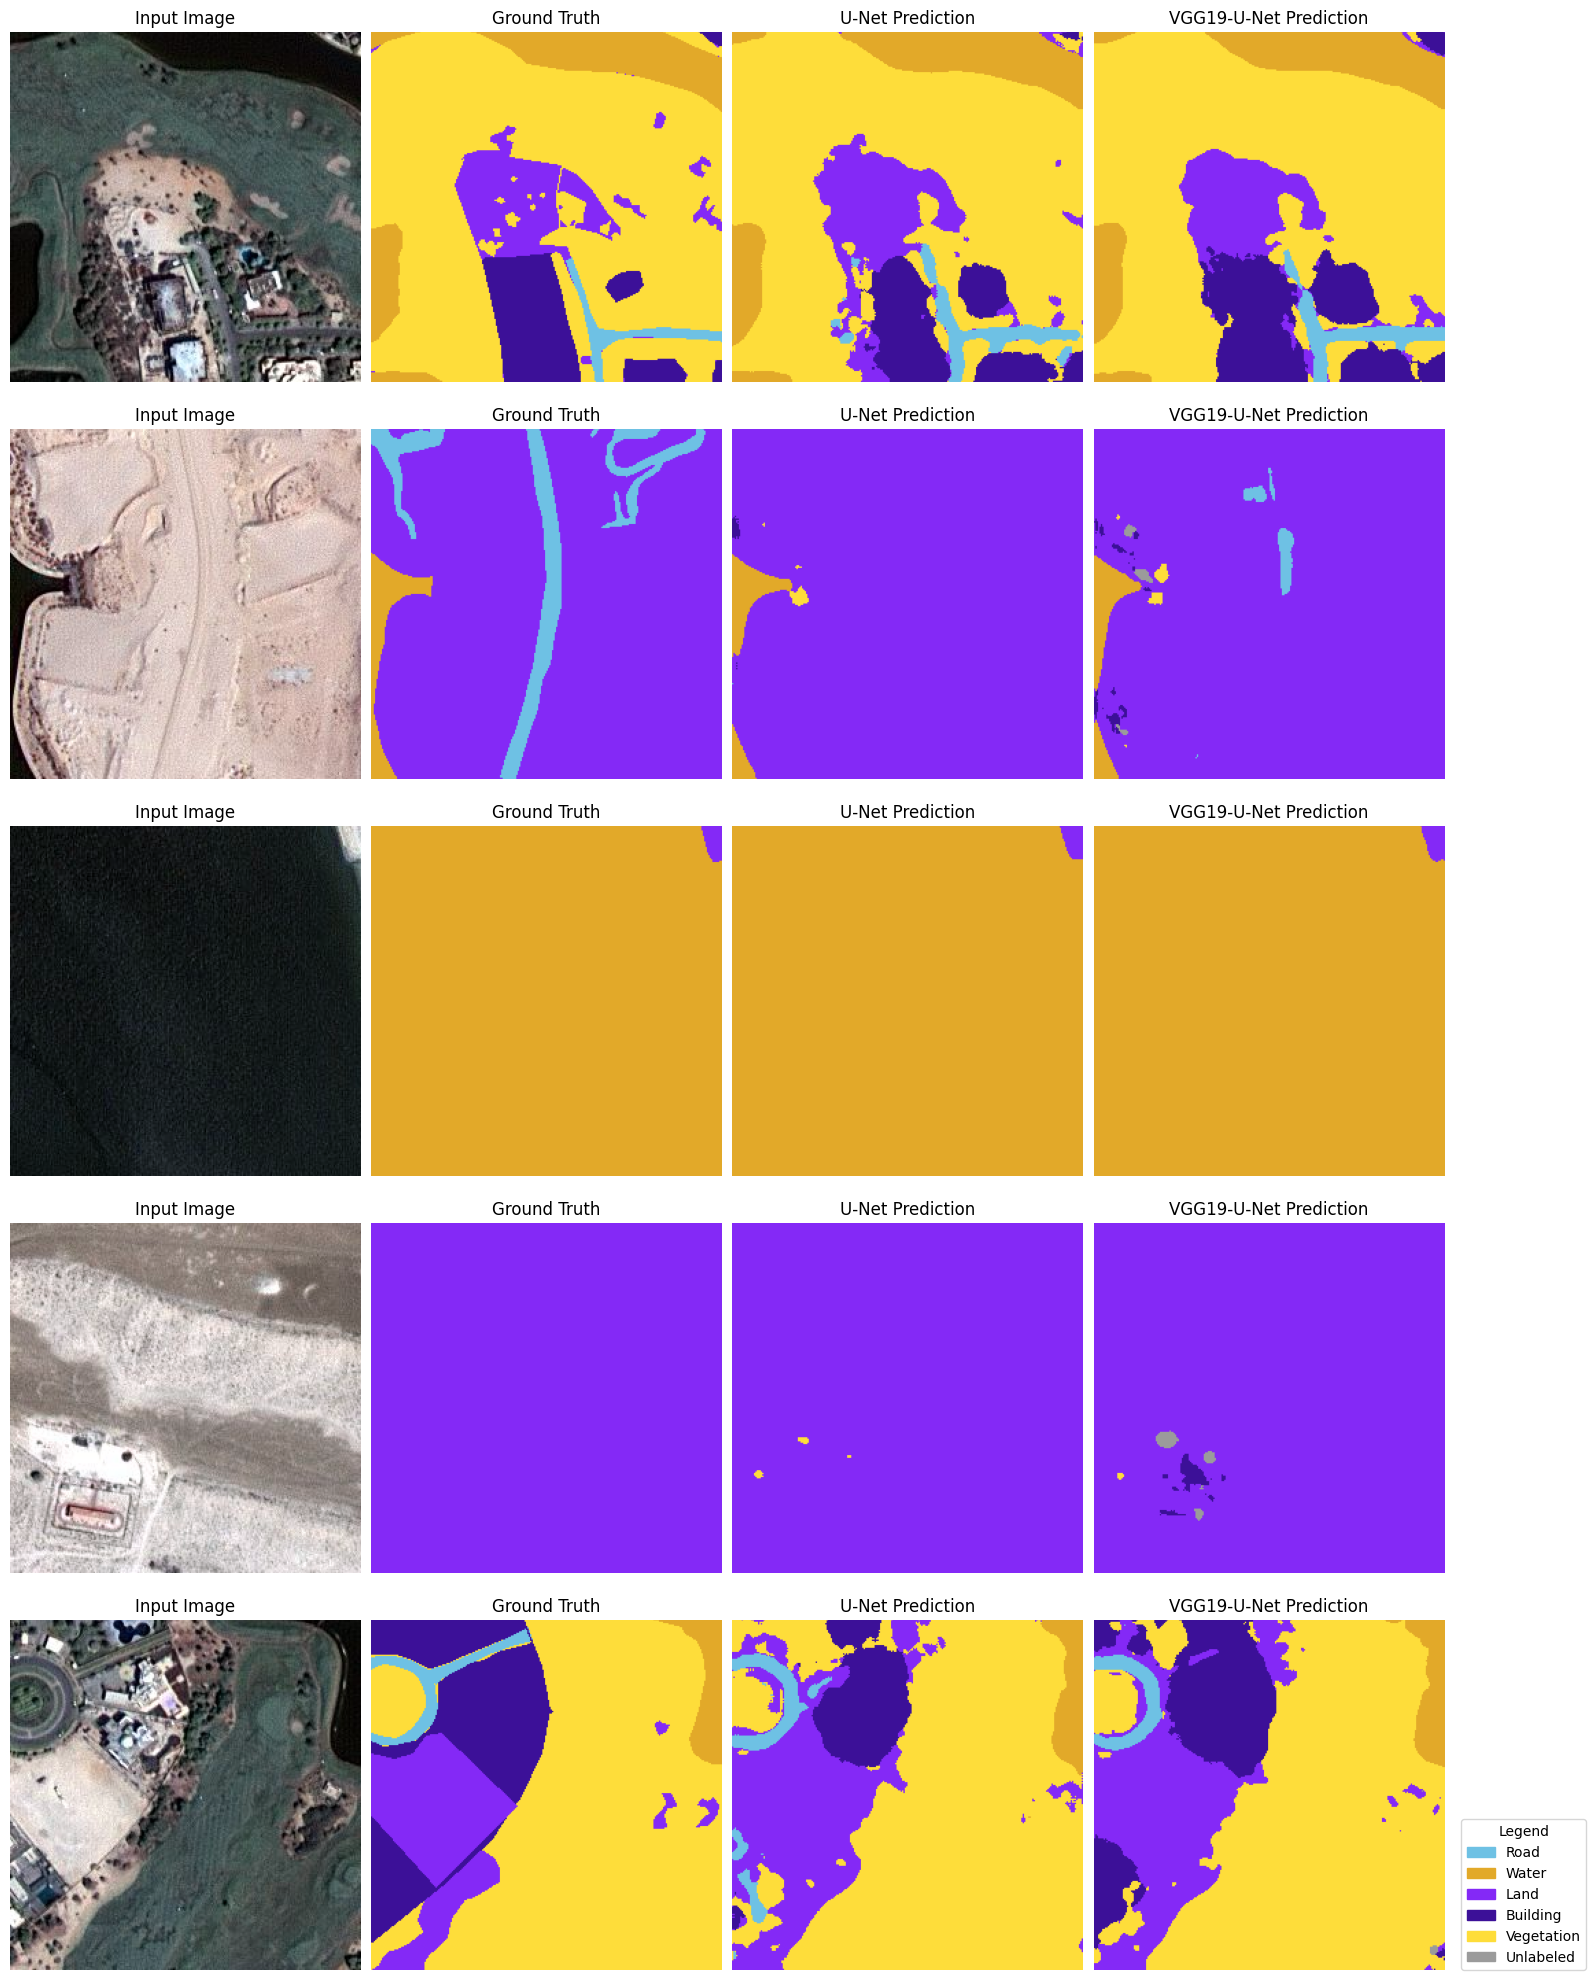

In [ ]:
compare_model_predictions(test_gen, n=5)

## Gradio based deployment

In [ ]:
! pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
image_size = (256, 256)
num_classes = 6

# Label to RGB mapping
class_colors = {
    0: [226, 169, 41],
    1: [132, 41, 246],
    2: [110, 193, 228],
    3: [60, 16, 152],
    4: [254, 221, 58],
    5: [155, 155, 155]
}

def label_to_rgb_mask(label_mask):
    h, w = label_mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label, rgb in class_colors.items():
        rgb_mask[label_mask == label] = rgb
    return rgb_mask

def preprocess_image(image):
    image_resized = cv2.resize(image, image_size)
    image_normalized = image_resized / 255.0
    return np.expand_dims(image_normalized, axis=0)  # Shape: (1, 256, 256, 3)

def predict_segmentation(image):
    preprocessed = preprocess_image(image)
    prediction = vgg_unet_model.predict(preprocessed)
    label_mask = np.argmax(prediction.squeeze(), axis=-1)
    rgb_mask = label_to_rgb_mask(label_mask)
    return rgb_mask

# Gradio app
interface = gr.Interface(
    fn=predict_segmentation,
    inputs=gr.Image(type="numpy", label="Upload Satellite Image"),
    outputs=[
        gr.Image(type="numpy", label="Predicted RGB Mask")
    ],
    title=" Satellite Segmentation (VGG19 U-Net)",
    description=(
        "This app uses a trained VGG19 U-Net model to perform semantic segmentation on satellite images. "
        "It predicts 6 classes (Water, Land, Road, Building, Vegetation, Unlabeled) and displays the RGB mask."
    ))

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://d883f958b72758d866.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


I0000 00:00:1751442884.511193     171 service.cc:148] XLA service 0x77fc100169f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751442884.511985     171 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751442884.512006     171 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751442884.770972     171 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


I0000 00:00:1751442892.427692     171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
